In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#changing directory to the dataset folder 
%cd /content/drive/MyDrive/YoloV5/
!unzip dataset.zip

/content/drive/MyDrive/YoloV5
Archive:  dataset.zip
replace images/test/images/wh_dresscode_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: images/test/images/wh_dresscode_0001.jpg  
replace images/test/images/wh_dresscode_0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/test/images/wh_dresscode_0002.jpg  
  inflating: images/test/images/wh_dresscode_0003.jpg  
  inflating: images/test/images/wh_dresscode_0004.jpg  
  inflating: images/test/images/wh_dresscode_0005.jpg  
  inflating: images/test/images/wh_dresscode_0006.jpg  
  inflating: images/test/images/wh_dresscode_0007.jpg  
  inflating: images/test/images/wh_dresscode_0052.jpg  
  inflating: images/test/images/wh_dresscode_0782.jpg  
  inflating: images/test/images/wh_dresscode_0783.jpg  
  inflating: images/test/images/wh_dresscode_0784.jpg  
  inflating: images/test/images/wh_dresscode_0785.jpg  
  inflating: images/test/images/wh_dresscode_0788.jpg  
  inflating: images/test/images/wh_dress

## **Setting up yolo v5 to train Warehouse Apparel Detector**

**Cloning Yolo v5 github**

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

**Installing Yolo v5 dependencies** 

In [4]:
# install dependencies as necessary
!pip install -r requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# Checking the GPU assigned 
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 8.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [5]:
#Yaml file for our data calsses generated through Roboflow
%cat /content/drive/MyDrive/YoloV5/dataset/data.yaml

train: /content/drive/MyDrive/YoloV5/dataset/train/images
val: /content/drive/MyDrive/YoloV5/dataset/test/images

nc: 5
names: ['hat','vest','goggles','glove','shoe']



## Model Configurations and Architecture 


In [6]:
# define number of classes based on YAML
import yaml
with open("/content/drive/MyDrive/YoloV5/dataset/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
print(f'num_classes : {num_classes}')

num_classes : 5


In [7]:
#Using yolo v5s model architecture to train the custom dataset 
%cat /content/drive/MyDrive/YoloV5/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [8]:
#creating a writetemplate function to write files using ipython

from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [9]:
#creating a writetemplate function to write files using ipython
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/drive/MyDrive/YoloV5/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [11]:
#checking our custom yolo configuration 
%cat /content/drive/MyDrive/YoloV5/yolov5/models/custom_yolov5s.yaml


# parameters
nc: 5  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

## Model Training 

***Arguments needed to be specified for model training***

- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training


In [12]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/YoloV5/yolov5
!python train.py --img 416 --batch 16 --epochs 100 --data '/content/drive/MyDrive/YoloV5/dataset/data.yaml' --cfg /content/drive/MyDrive/YoloV5/yolov5/models/custom_yolov5s.yaml --weights '' --name yolov5m_results

/content/drive/MyDrive/YoloV5/yolov5
github: ⚠️ WARNING: code is out of date by 741 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='/content/drive/MyDrive/YoloV5/yolov5/models/custom_yolov5s.yaml', data='/content/drive/MyDrive/YoloV5/dataset/data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5m_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5m_results4', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & 

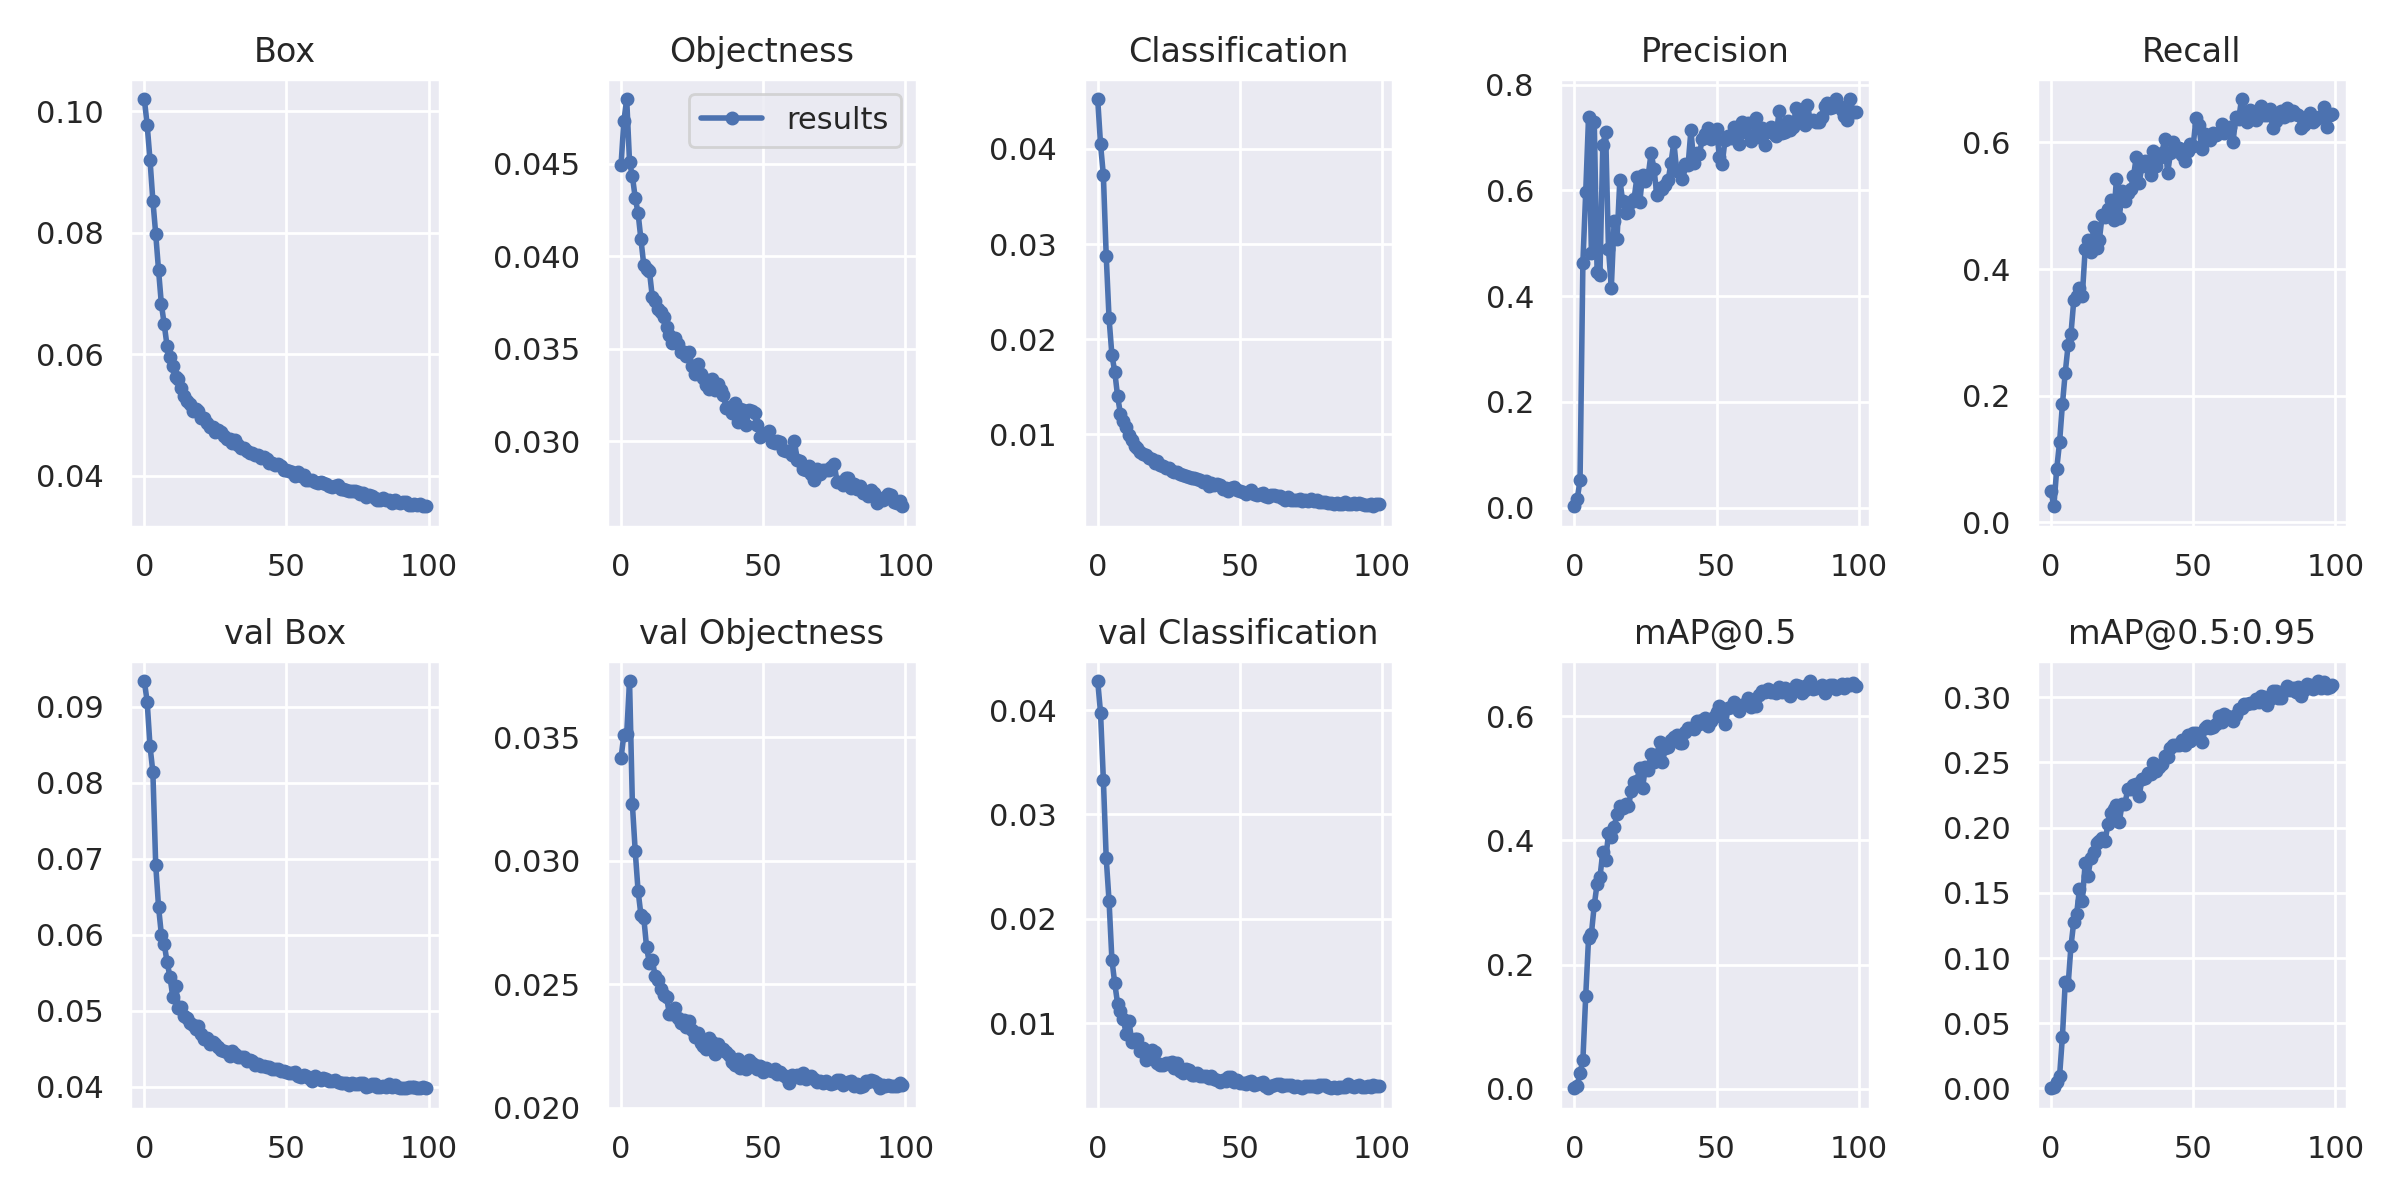

In [17]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


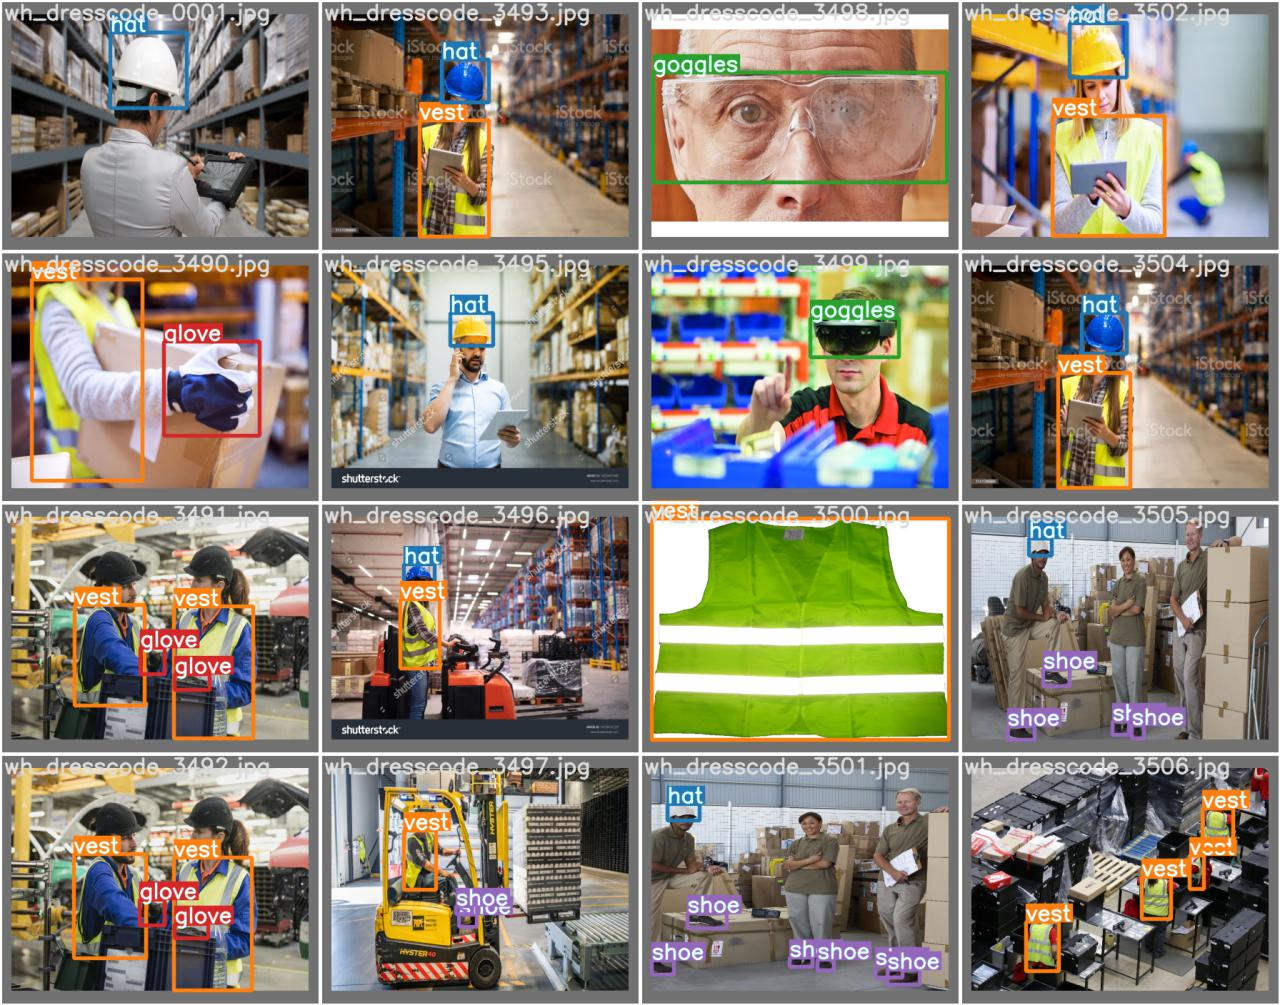

In [20]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


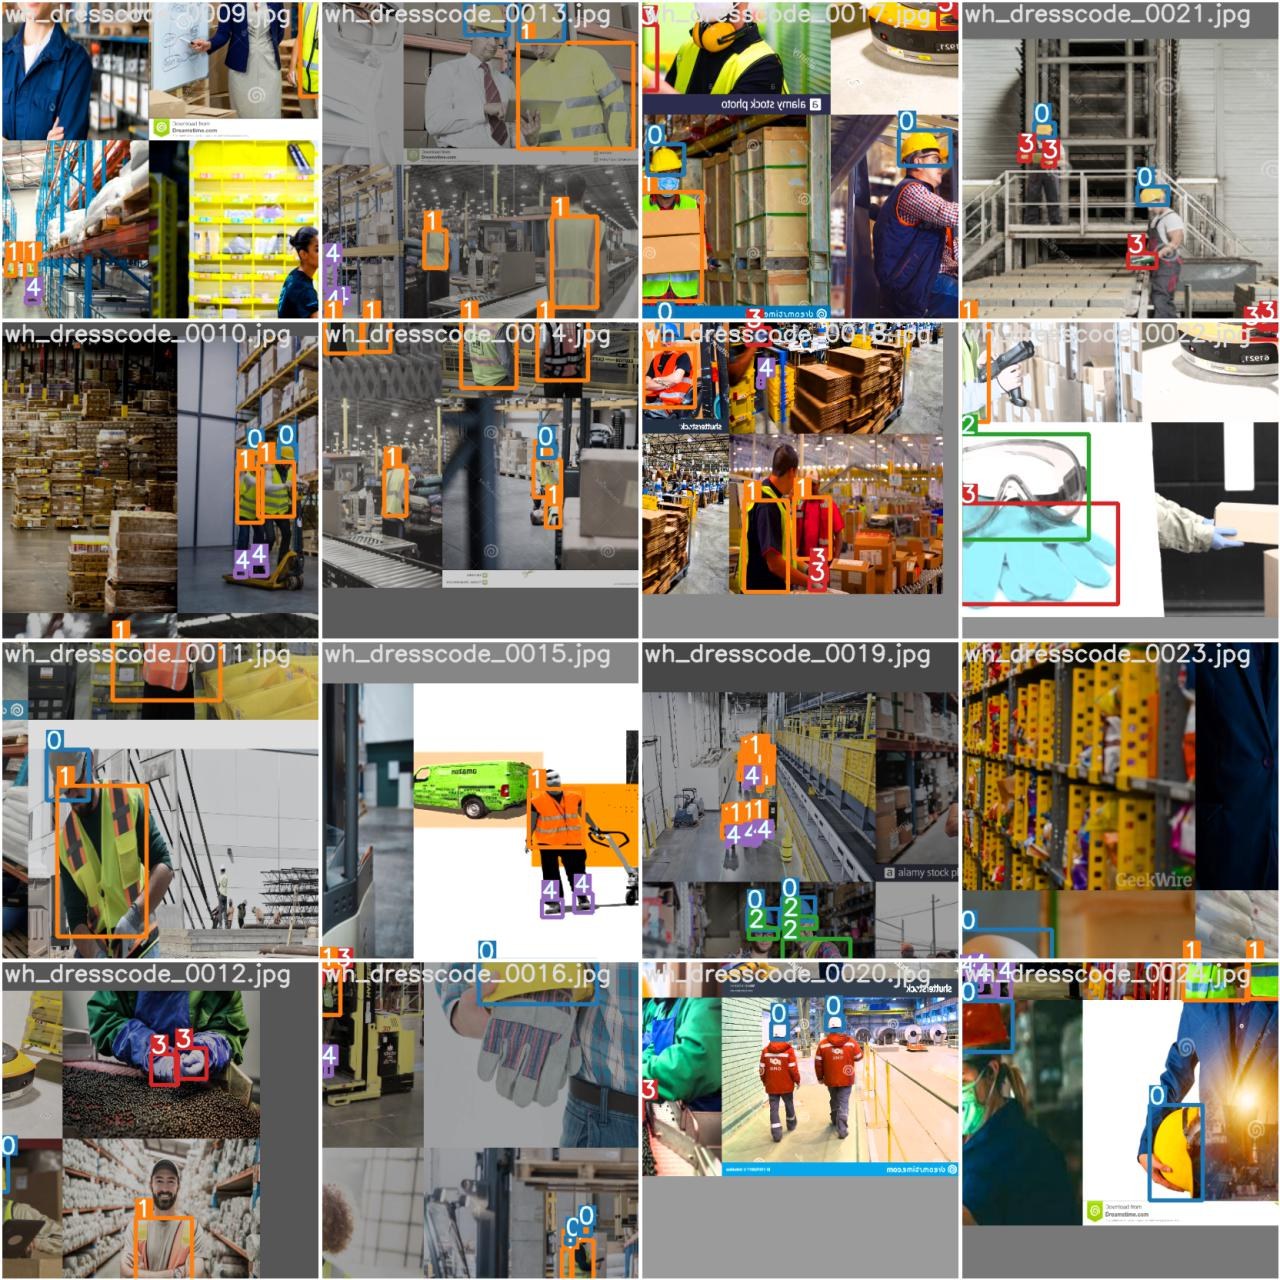

In [21]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/drive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/train_batch0.jpg', width=900)

#Running Inference  With Trained Weights
Running inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [22]:
# trained weights are saved by default in our weights folder
%ls runs/

ls: cannot access 'runs/': No such file or directory


In [24]:
%ls /content/drive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/weights

best.pt  last.pt


In [25]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# useing the best weights to detect 

!python detect.py --weights /content/drive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/YoloV5/dataset/test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/YoloV5/dataset/test/images', update=False, view_img=False, weights=['/content/drive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7064698 parameters, 0 gradients, 16.4 GFLOPS
image 1/1059 /content/drive/MyDrive/YoloV5/dataset/test/images/wh_dresscode_0001.jpg: 320x416 1 hat, Done. (0.012s)
image 2/10

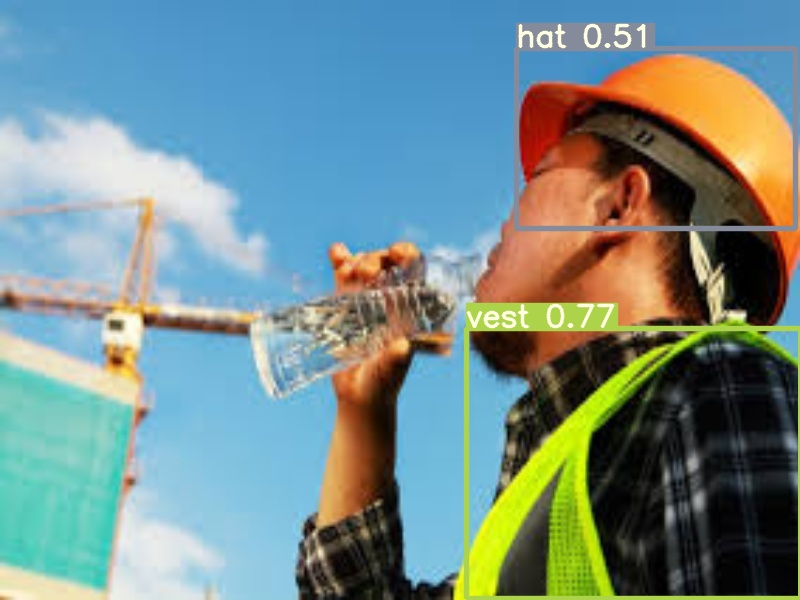

In [26]:
#display inference on test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/YoloV5/yolov5/yolov5/runs/detect/exp/wh_dresscode_0787.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

### **Saving the Model Weights**

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
%cp /content/gdrive/MyDrive/YoloV5/yolov5/runs/train/yolov5m_results4/weights/best.pt /content/gdrive/MyDrive/YoloV5

In [34]:
%ls /content/gdrive/MyDrive/YoloV5

 best.pt    dataset.zip  'Warehouse Apparel Detector.ipynb'
 dataset/   images/       yolov5/
